In [213]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.2.1
certifi                      2022.12.7
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.5
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
entrypoints                  0.4
etils                        1.0.0
executing                    1.2.0
flatbuffers                  23.1.21
fonttools                    4.38.0
gast                         0.5.3
google-auth                  2.16.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
googleapis-common-protos     1.5

You should consider upgrading via the 'C:\Deep Learning Projects\AngCommands\env_angmincommands\Scripts\python.exe -m pip install --upgrade pip' command.


In [214]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 tensorflow-io==0.25.0 tensorflow_datasets matplotlib

You should consider upgrading via the 'C:\Deep Learning Projects\AngCommands\env_angmincommands\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

2. ŚCIEŻKI DO PLIKÓW

In [4]:
COMMAND_FILE = os.path.join('single', 'command', '0a2b400e_nohash_0.wav')
NOT_COMMAND_FILE = os.path.join('single', 'not_command', '00b01445_nohash_0.wav')

In [5]:
COMMAND_FILE

'single\\command\\0a2b400e_nohash_0.wav'

In [6]:
def load_wav_16k_mono(file_path):
    # Load encoded wav file
    file_contents = tf.io.read_file(file_path)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from ?Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
def load_wav_8k_mono(file_path):
    # Load encoded wav file
    file_contents = tf.io.read_file(file_path)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from ?Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=8000)
    return wav

In [8]:
def load_wav_4k_mono(file_path):
    # Load encoded wav file
    file_contents = tf.io.read_file(file_path)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from ?Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=4000)
    return wav

In [9]:
wave = load_wav_16k_mono(COMMAND_FILE)
nwave = load_wav_16k_mono(NOT_COMMAND_FILE)

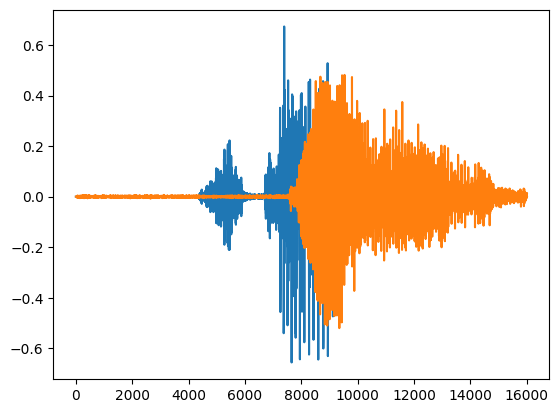

In [10]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

// ---------------------------------------------

3. Create Tensorflow Dataset

// ---------------------------------------------

3.1 Define Paths to Positive and Negative Data

In [11]:
POS = os.path.join('single', 'command')
NEG = os.path.join('single', 'not_command')

3.2 Create Tensorflow Datasets

In [12]:
pos_ds = tf.data.Dataset.list_files(POS +'\*.wav')
neg_ds = tf.data.Dataset.list_files(NEG +'\*.wav')

In [13]:
pos_ds.as_numpy_iterator().next()

b'single\\command\\02e42bed_nohash_0.wav'

3.3 Add labels and Combine Positive and Negative Samples

In [14]:
positives = tf.data.Dataset.zip((pos_ds, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos_ds)))))
negatives = tf.data.Dataset.zip((neg_ds, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg_ds)))))
data = positives.concatenate(negatives)

In [15]:
positives.as_numpy_iterator().next()

(b'single\\command\\1a073312_nohash_0.wav', 1.0)

In [16]:
negatives.as_numpy_iterator().next()

(b'single\\not_command\\94d370bf_nohash_0.wav', 0.0)

In [17]:
data.shuffle(1000).as_numpy_iterator().next()

(b'single\\not_command\\21832144_nohash_2.wav', 0.0)

// ---------------------------------------------

4. Determine Average Length of a Capuchin Call

// ---------------------------------------------

4.1 Calculate Wave Cycle Length

In [18]:
lengths = []
for file in os.listdir(os.path.join('single', 'command')):
    tensor_wave = load_wav_16k_mono(os.path.join('single', 'command', file))
    lengths.append(len(tensor_wave))

In [19]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=15812>

In [20]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=5803>

In [21]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=16000>

// ---------------------------------------------

5. Build Preprocessing Function to Convert to Spectrogram

// ---------------------------------------------

5.1 Build Preprocessing Function

In [22]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(wav), dtype=tf.float32)
    
    wav = tf.concat([zero_padding, wav],0)
    
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

5.2 Test Out the Function and Viz the Spectrogram

In [23]:
file_path, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [24]:
spectrogram, label = preprocess(file_path, label)

In [26]:
spectrogram

<tf.Tensor: shape=(491, 257, 1), dtype=float32, numpy=
array([[[4.38677311e-01],
        [6.24326050e-01],
        [8.67331266e-01],
        ...,
        [1.88891772e-05],
        [1.47573346e-05],
        [7.82310963e-06]],

       [[1.35797739e-01],
        [5.79846561e-01],
        [7.81534135e-01],
        ...,
        [1.92243224e-05],
        [1.21878111e-05],
        [7.56233931e-06]],

       [[2.80554205e-01],
        [5.98702669e-01],
        [6.41035378e-01],
        ...,
        [1.52983339e-05],
        [1.32977902e-05],
        [2.83122063e-06]],

       ...,

       [[4.08243954e-01],
        [7.73025215e-01],
        [1.00304031e+00],
        ...,
        [1.74550187e-05],
        [1.90624523e-05],
        [1.36941671e-05]],

       [[5.12976833e-02],
        [7.33678937e-01],
        [1.13209069e+00],
        ...,
        [1.43578236e-05],
        [1.18452535e-05],
        [4.55603004e-06]],

       [[4.38304842e-01],
        [7.60207236e-01],
        [1.12470460e+00],

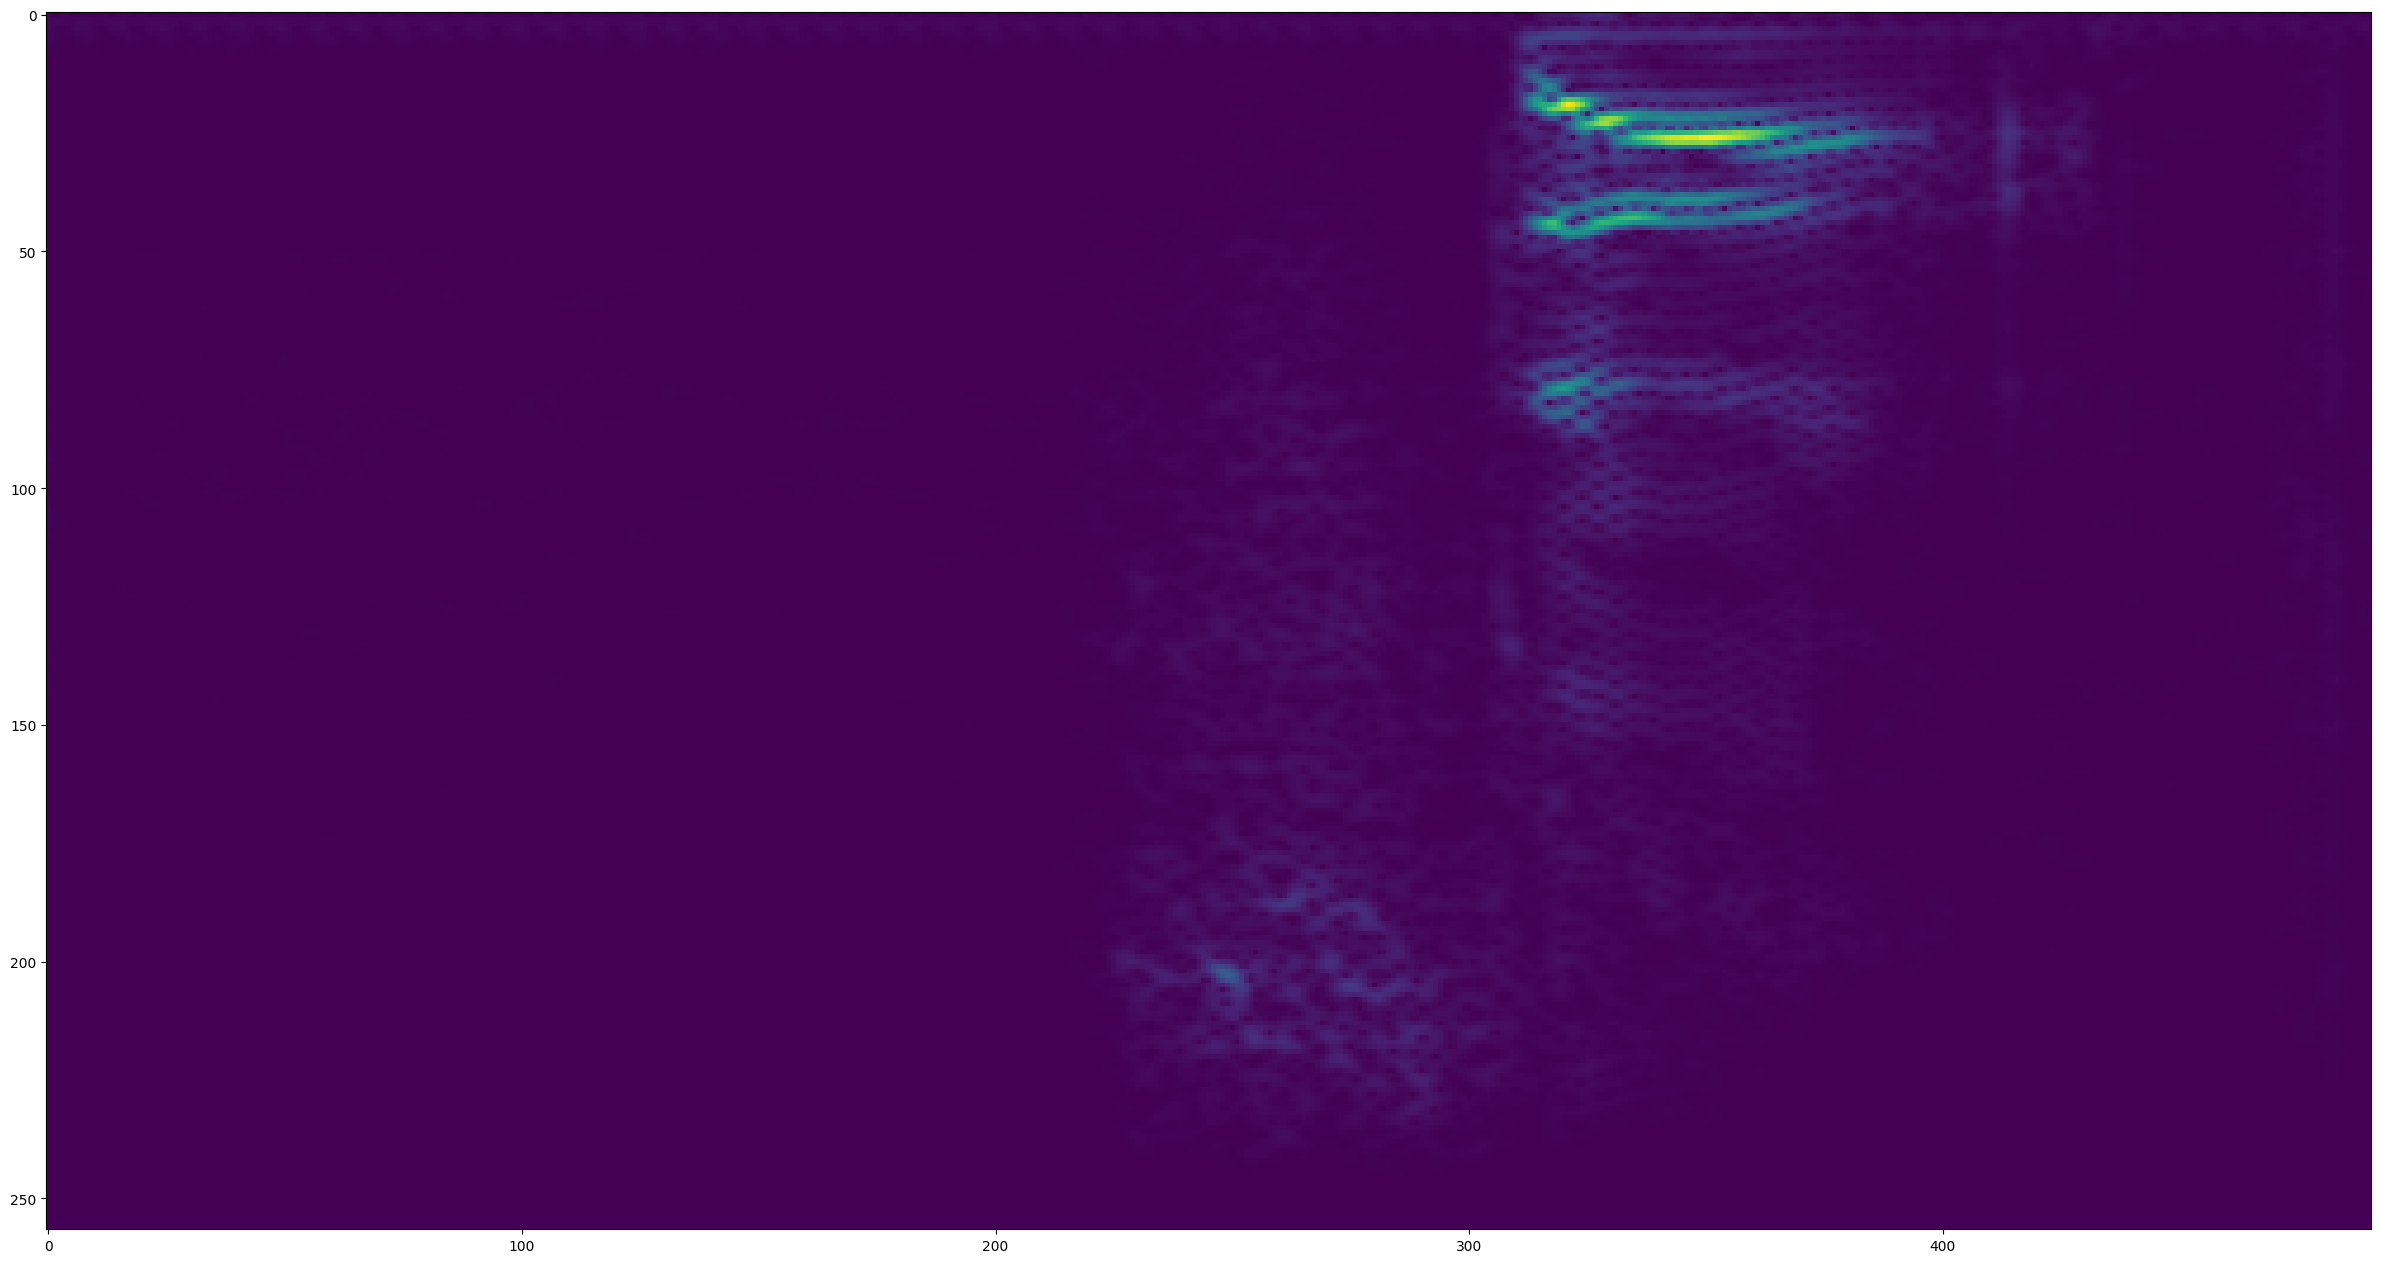

In [25]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

// ---------------------------------------------

6. Create Training and Testing Partitions

// ---------------------------------------------

6.1 Create a Tensorflow Data Pipeline

In [407]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16) #16 samples at the time
data = data.prefetch(8)

In [410]:
len(data)

63

6.2 Split into Training and Testing Partitions

In [411]:
train = data.take(40)
test = data.skip(40).take(23)

6.3 Test One Batch

In [421]:
samples, labels = train.as_numpy_iterator().next()

In [422]:
samples.shape

(16, 491, 257, 1)

In [423]:
labels

array([1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

// ---------------------------------------------

7. Build Deep Learning Model

// ---------------------------------------------

7.1 Load Tensorflow Dependencies

In [425]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

7.2 Build Sequential Model, Compile and View Summary

In [426]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [427]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [428]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 489, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 487, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 1971376)           0         
                                                                 
 dense (Dense)               (None, 128)               252336256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 252,338,865
Trainable params: 252,338,865
Non-trainable params: 0
_________________________________________________________________


// ---------------------------------------------

7.3 Fit Model, View Loss and KPI Plots

// ---------------------------------------------

In [429]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
40/40 [==============================] - 197s 5s/step - loss: 5.7169 - recall: 0.6011 - precision: 0.5765 - val_loss: 0.4733 - val_recall: 0.6822 - val_precision: 0.9012
Epoch 2/4
40/40 [==============================] - 153s 4s/step - loss: 0.3752 - recall: 0.6032 - precision: 0.8702 - val_loss: 0.2129 - val_recall: 0.8796 - val_precision: 0.9314
Epoch 3/4
40/40 [==============================] - 137s 3s/step - loss: 0.1897 - recall: 0.8492 - precision: 0.9337 - val_loss: 0.1314 - val_recall: 0.9000 - val_precision: 0.9612
Epoch 4/4
40/40 [==============================] - 140s 3s/step - loss: 0.1614 - recall: 0.8969 - precision: 0.9355 - val_loss: 0.0765 - val_recall: 0.9524 - val_precision: 0.9804


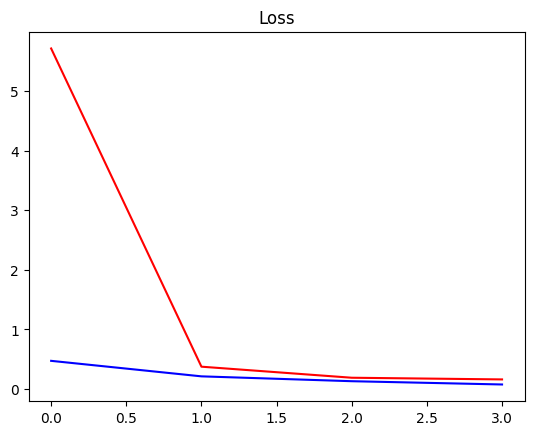

In [430]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

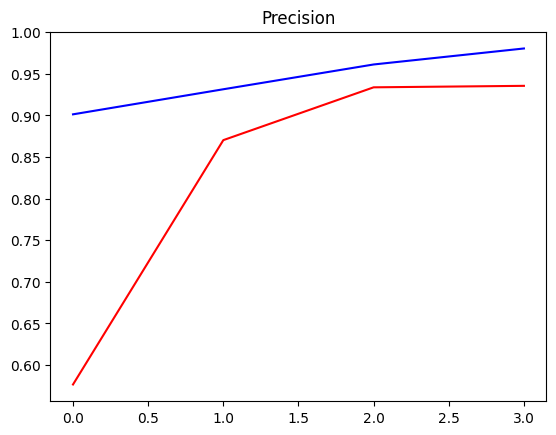

In [431]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

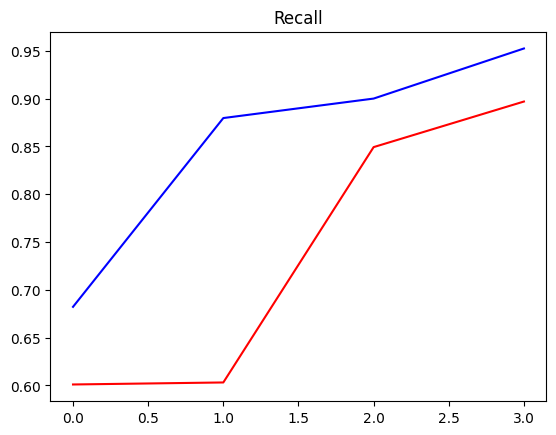

In [432]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

// ---------------------------------------------

8. Make a Prediction on a Single Clip

// ---------------------------------------------

8.1 Get One Batch and Make a Prediction

In [465]:
X_test, y_test = test.as_numpy_iterator().next()

In [466]:
X_test.shape

(16, 491, 257, 1)

In [467]:
y_test.shape

(16,)

In [468]:
yhat = model.predict(X_test)

In [469]:
yhat

array([[3.74067158e-01],
       [1.77245289e-01],
       [9.80208814e-01],
       [1.00000000e+00],
       [9.93113399e-01],
       [3.39225306e-12],
       [7.54553080e-02],
       [9.99999583e-01],
       [1.53701141e-08],
       [3.26602012e-01],
       [3.10313702e-03],
       [1.10493775e-05],
       [7.63154030e-03],
       [1.71426766e-08],
       [1.71220303e-03],
       [8.24887872e-01]], dtype=float32)

8.2 Convert Logits to Classes

In [470]:
yhat = [1 if prediction > 0.75 else 0 for prediction in yhat]

In [471]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [472]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [473]:
yhat

[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]

In [474]:
y_test

array([0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)